# Timeseries uncertainty demo

In this notebook we use the backend API to retrieve a time series and then plot it with the respective uncertainty bounds.

In [6]:
%matplotlib widget

import httpx
import matplotlib.pyplot as plt
import pandas as pd

coverage_identifier = "tas_seasonal_absolute_model_ensemble-rcp26-DJF"
point_coords = "POINT(11.5469 44.9524)"
date_range = "../.."
api_url = f"http://webapp:5001/api/v2/coverages/time-series/{coverage_identifier}"


def _parse_to_dataframe(time_series: dict):
    df = pd.DataFrame.from_records(time_series["values"])
    df["datetime"] = pd.to_datetime(df["datetime"])
    df.set_index("datetime", inplace=True)
    return df    

In [7]:
raw_response = httpx.get(
    api_url,
    params={
        "coords": point_coords,
        "datetime": date_range,
        "include_coverage_data": True,
        "include_observation_data": False,
        "coverage_data_smoothing": [
            "MOVING_AVERAGE_11_YEARS",
        ],
        "include_coverage_uncertainty": True,
        "include_coverage_related_data": False,
    }
)
raw_response.raise_for_status()

raw_series = raw_response.json()["series"]

series = {s["name"]: s for s in raw_series}
dfs = {v["name"]: _parse_to_dataframe(v) for v in series.values()}

In [4]:
dfs

{'tas_seasonal_absolute_model_ensemble-rcp26-DJF':                                      value
 datetime                                  
 1976-02-15 12:00:00+00:00         2.640222
 1977-02-14 17:57:04.390000+00:00  4.131799
 1978-02-14 23:54:08.780000+00:00  2.913995
 1979-02-15 05:51:13.171000+00:00  3.958703
 1980-02-15 11:48:17.561000+00:00  3.593713
 ...                                    ...
 2095-02-15 00:11:42.439000+00:00  4.252954
 2096-02-15 06:08:46.829000+00:00  4.549829
 2097-02-14 12:05:51.220000+00:00  4.398187
 2098-02-14 18:02:55.610000+00:00  4.646112
 2099-02-15 00:00:00+00:00         4.863336
 
 [124 rows x 1 columns],
 'tas_seasonal_absolute_model_ensemble-rcp26-DJF__MOVING_AVERAGE_11_YEARS':                                      value
 datetime                                  
 1981-02-14 17:45:21.951000+00:00  3.482441
 1982-02-14 23:42:26.341000+00:00  3.479819
 1983-02-15 05:39:30.732000+00:00  3.424352
 1984-02-15 11:36:35.122000+00:00  3.497647
 1985-02-14 

In [8]:
smoothed_ma11_coverage_df = dfs[f"{coverage_identifier}__MOVING_AVERAGE_11_YEARS"]
smoothed_ma11_uncertainty_lower_coverage_df = [
    df for name, df in dfs.items() 
    if "lower_uncertainty" in name and "MOVING_AVERAGE_11_YEARS" in name
][0] 
smoothed_ma11_uncertainty_upper_coverage_df = [
    df for name, df in dfs.items() 
    if "upper_uncertainty" in name and "MOVING_AVERAGE_11_YEARS" in name
][0]

### Plotting

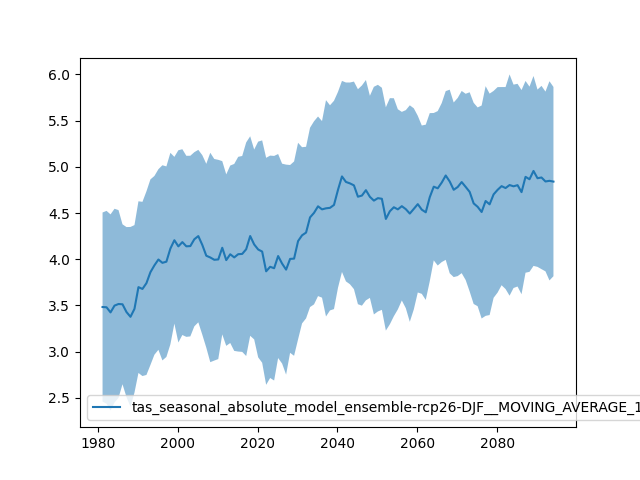

In [9]:
fig, ax = plt.subplots()
smoothed_ma11_tas_line, = ax.plot(smoothed_ma11_coverage_df, label=series[f"{coverage_identifier}__MOVING_AVERAGE_11_YEARS"]["name"])
ax.fill_between(
    smoothed_ma11_uncertainty_lower_coverage_df.index, 
    smoothed_ma11_uncertainty_lower_coverage_df.value, 
    smoothed_ma11_uncertainty_upper_coverage_df.value,
    alpha=0.5,
    linewidth=0
)
ax.legend()

In [42]:
ax.clear()